# Regresión logística con descenso del gradiente

In [1]:
import matplotlib
%matplotlib inline

from sklearn.linear_model    import LogisticRegression
from sklearn.datasets        import make_circles, make_blobs
from sklearn.model_selection import train_test_split
from matplotlib              import pyplot as plt
from sklearn.metrics         import confusion_matrix

import pandas as pd
import numpy as np

import celluloid



La función logística ajusta una probabilidad y tiene muchas propiedades como ser continua y derivable. La vamos a ocupar para determinar con qué probabilidad pertenece algún vector $x$ a alguna clase $C_i$ de puntos. Y ese va a ser precisamente nuestro problema, considerando que ya tengo una distribución de puntos agrupados en clases, así cómo la distribución de cada clase, es decir 

$$
Pr(x|C_i)  ;  Pr(C_i)
$$

Cómo entonces puedo determinar la clase dado que tengo un punto nuevo, es decir, poder computar

$$
Pr(C_i|x)
$$

Es decir, nos gustaría construir un **modelo generativo**.

## Sigmoide

Consideren el caso binario, $i \in {1,2}$, y donde queremos saber la probabilidad de ajustar la probabilidad _a posteriori_ de $C_1$ de acuerdo con Bayes

$$
p(C=C_1 | x ) = \frac {p(x|C_1)p(C_1)} {p(x|C_1)p(C_1) + p(x|C_2)p(C_2)}
$$

Si dividimos numerador y denominador de cada término en la expresión anterior por $p(x|C_1)p(C_1)$ obtenemos:

$$
p(C=C_1 | x ) = \frac {1} {1 + \frac {p(x|C_2)p(C_2)} {p(x|C_1)Pr(C_1)}}
$$


Sea $a =  \log \left( \frac {p(x|C_1)p(C_1)} {p(x|C_2)p(C_2)}\right)$ entonces podemos reexpresar la función anterior como:

$$
\sigma (a) = \frac {1} {1 + \exp(-a)}
$$

que es la función *sigmoide*

Que tiene varias propiedades como $\sigma (-a) = 1 - \sigma(a)$ y que su inverso es

$$
a = \log \left ( \frac {\sigma} {1 - \sigma} \right )
$$

que es la razón de las probabilidades $\log \left [ \frac {p(C_1| x)} {p(C_2|x)}  \right]$. Para más de dos clases lo que obtenemos es la *exponencial normalizada* o *softmax*.



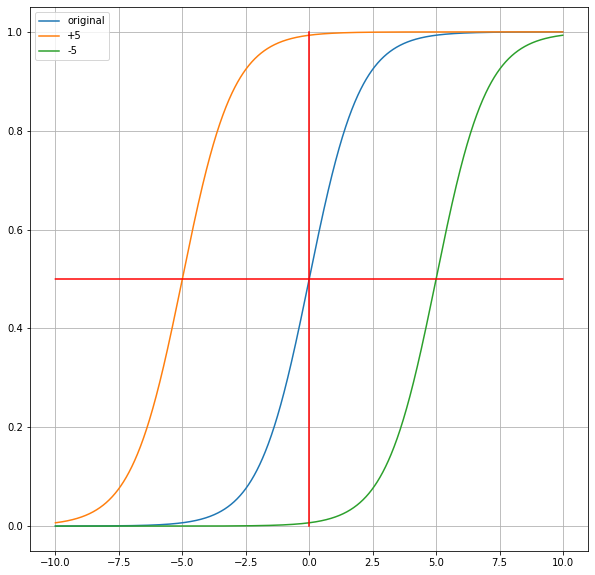

In [2]:
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

X  = np.arange(-10,10,1/100)
Y  = sigmoide(X)
Y2 = sigmoide(X+5)
Y3 = sigmoide(X-5)

fig = plt.figure(figsize=(10,10))
plt.plot(X,Y, label="original")
plt.plot(X,Y2, label="+5")
plt.plot(X,Y3, label="-5")
plt.plot([0.,0.], [0.,1.], 'r')
plt.plot(X, 0*Y+0.5, 'r')
plt.grid()
plt.legend()

Si yo tengo una serie de puntos en $\mathcal{R^n}; n>2$ ¿cómo encuentro el mejor margen que los divide? (¿Cómo puedo ajustar la verosimilitud dada por los datos?) 

Es decir yo quiero maximizar la verosimilitud de un proceso de Bernoulli

$$
\operatorname{Pr}\left(Y=y_{i} \mid x_{i}\right)=\prod s_{\beta}\left(x_{i}\right)^{y_{i}}\left(1-s_{\beta}\left(x_{i}\right)\right)^{1-y_{i}}
$$

Pero como trabajar con productos es muy difícil, entonces voy a ocupar la función $\log$

$$
\mathcal{L}=\log (\operatorname{Pr})=\sum y_{i} \log \left(s_{\beta}\left(x_{i}\right)\right)+\left(1-y_{i}\right)\left(\log \left(1-s_{\beta}\left(x_{i}\right)\right)\right)
$$

In [3]:
X,y = make_blobs(centers=2, n_features=2, n_samples=500, center_box=[(-4,3),(5,-1)],random_state=213)
Xn, Xt, yn, yt = train_test_split(X,y)

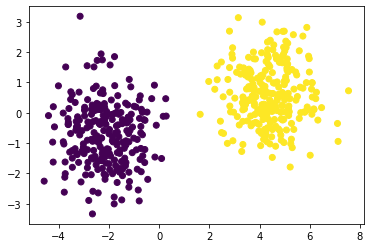

In [4]:
plt.scatter(X[:,0],X[:,1],c=y)

Entonces una vez que tenemos los datos nosotros queremos buscar una lista de términos $\theta_j$ que van a **ponderar** a los terminos $x_j$, es decir
$$
y_j = s (\theta_0 \cdot 1 + \theta_1 x_1 + \ldots + \theta_j x_j + \ldots + \theta_n x_n) = s(< (1,x_1,\ldots, x_n), \theta>)
$$

para encontrar estos términos 
Una opción para encontrar las $\theta$ que máximas las probabilidades de la sigmoide y por lo tanto de $\mathcal{L}$ es el descenso del gradiente.

$$
\theta(t+1) = \theta(t) - \eta \cdot \nabla J(\theta(t))
$$

Y como función $J$ podemos ocupar a $-\mathcal{L}$

$$
\begin{aligned}
\frac{\partial J}{\partial \theta_{j}} &=-y_{i} \frac{s_{\theta}\left(x_{i}\right)\left(1-s_{\theta}\left(x_{i}\right)\right)}{s_{\theta}\left(x_{i}\right)} x_{j}-\left(y_{i}-1\right) \frac{s_{\theta}\left(x_{i}\right)\left(1-s_{\theta}\left(x_{i}\right)\right)}{1-s_{\theta}\left(x_{i}\right)} x_{j} \\
\frac{\partial J}{\partial \theta_{j}} &=-\left[y_{i}\left(1-s_{\theta}\left(x_{i}\right)\right)+\left(y_{i}-1\right) s_{\theta}\left(x_{i}\right)\right] x_{j} \\
\frac{\partial J}{\partial \theta_{j}} &=-\left[y_{i}-s_{\theta}\left(x_{i}\right)\right] x_{j} \\
\frac{\partial J}{\partial \theta_{j}} &=\left[s_{\theta}\left(x_{i}\right)-y_{i}\right] x_{j}
\end{aligned}
$$

Haciendo $\Delta \equiv s_{\theta}\left(x_{i}\right)-y_{i}$ obtengo

$$
\frac{\partial J}{\partial \theta_{j}} = \Delta_i x_j
$$

In [16]:
def agrega_bias(X):
    n,d = X.shape
    u = np.ones((n,1))
    return np.hstack((u,X))

def estandariza(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

def normaliza(X):
    rg = np.amin(X,axis=0) - np.amax(X,axis=0)
    return (X+X.min(axis=0))/rg


def score(th,X):
    return sigmoide(np.dot(X,th))

def gradiente(w,X,y):
    h = sigmoide(np.dot(X,w))
    z = h.T - y
    gr = np.dot(X.T, z.T)
    return gr

sigmoide = lambda z: 1/(1 + np.exp(-z))
loglikelihood = lambda H,y: (-np.dot(y,np.log(H)) - np.dot((1-y),np.log(1-H))).sum()

def grad_desc(X,y,iters, a=0.01,t=100, tol=1e-4):
    #gr = lambda w, X, y: dot(X.T, (sigmoide(w.T,X.T) - y).T)
    n, d = X.shape
    pesos = np.random.ranf((1,d))
    w = pesos[-1]
    h  = sigmoide(np.dot(X,w))
    j  = loglikelihood(h,y)
    costos = [j]
    for i in range(iters):
        gr = gradiente(w,X,y)
        w -= a*gr
        pesos  = np.vstack((pesos,w))
        h  = sigmoide(np.dot(X,w))
        j  = loglikelihood(h,y)
        costos.append(j)
        if(i%t==0 or j < tol):
            print('{0}:{1}'.format(i,j))
        if(j<tol):
            break
    return w, pesos, costos

Xs = normaliza(X)
#plt.scatter(Xs[:,0],Xs[:,1],c=y)
Xb = agrega_bias(Xs)
Xt, Xp, yt, yp = train_test_split(Xb, y)
wf, W, J = grad_desc(Xt,yt,30000,0.05, t=1000)

0:877.8852161263875
1000:1.3091968437970052
2000:0.8410167972435578
3000:0.6464553475939552
4000:0.5351068265101179
5000:0.4613627612636911
6000:0.40820831147143494
7000:0.36770958961301947
8000:0.3356196051801254
9000:0.3094390855117243
10000:0.2875916502146357
11000:0.26902881886167906
12000:0.253023320965733
13000:0.2390532051476262
14000:0.22673315364192634
15000:0.21577187585789787
16000:0.2059446511122085
17000:0.1970750507371024
18000:0.18902242620614246
19000:0.18167313361588272
20000:0.17493424595525242
21000:0.1687289619213885
22000:0.16299319652356786
23000:0.1576730106767404
24000:0.15272264667600138
25000:0.14810300801828608
26000:0.14378046970814584
27000:0.13972593752977397
28000:0.13591409708922542
29000:0.13232280907609284


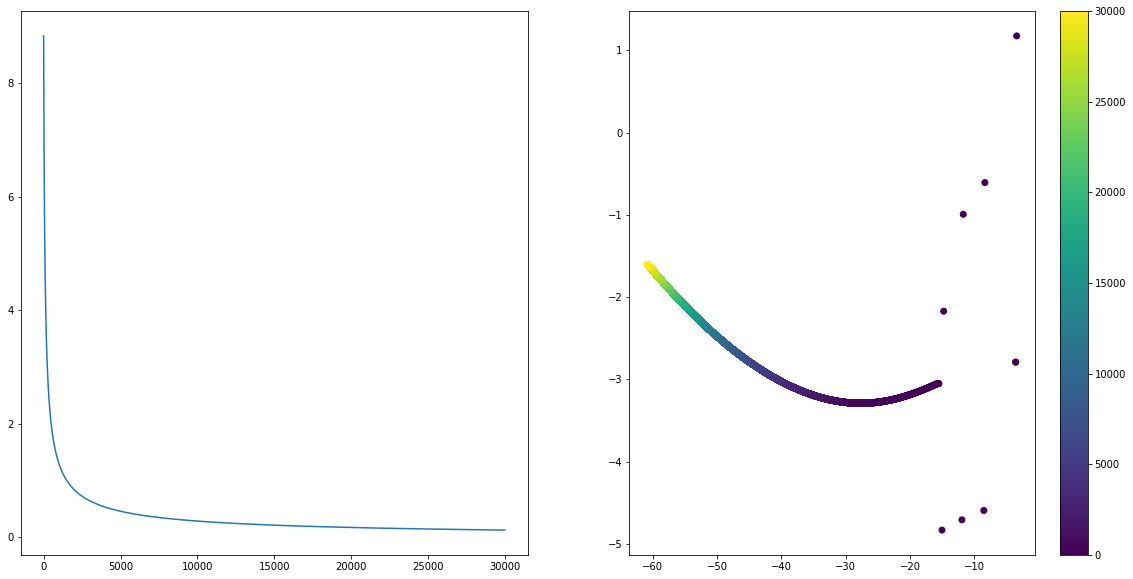

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.plot(J[20:])
im = ax2.scatter(W[:,1], W[:,2], c=range(len(W)))
fig.colorbar(im,ax=ax2)

In [18]:
h = sigmoide(np.dot(Xp,wf))
S = loglikelihood(h,yp)
print("Erorr {0}".format(S/2))
print(confusion_matrix(np.round(h), yp))

Erorr 0.006386769261083126
[[63  0]
 [ 0 62]]


In [96]:
for vv,vp in zip(h,yp):
    print("{0} : {1}".format(round(vv),vp))



0 : 0
0 : 0
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
0 : 0
1 : 1
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
1 : 1
1 : 1
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
0 : 0
1 : 1
0 : 0
1 : 1
1 : 1
1 : 1
1 : 1
0 : 0
1 : 1
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
0 : 0
1 : 1
0 : 0
1 : 1
0 : 0
1 : 1
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0
0 : 0
1 : 1
1 : 1
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0
1 : 1
1 : 1
1 : 1
0 : 0


## Dataset sonar



In [93]:
columnas = [i for i in range(60)]+ ['clasif']
sonar_dataset = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", 
                            header=0)
sonar_dataset.columns = columnas

In [124]:
data = np.array(sonar_dataset[columnas[:-1]])
#data = normaliza(data)
#print(data)
clsf = np.array([1 if c=='M' else 0 for c in sonar_dataset['clasif']])

In [125]:
Xt, Xs, yt, ys = train_test_split(data,clsf)

In [126]:
wf, W, J = grad_desc(Xt,yt,40000,0.005)

0:[379.47019966]
100:[70.53935796]
200:[64.45418259]
300:[61.2775111]
400:[59.15124986]
500:[57.5622837]
600:[56.29708467]
700:[55.24644007]
800:[54.34752323]
900:[53.56131173]
1000:[52.86215482]
1100:[52.23240042]
1200:[51.65941735]
1300:[51.13385501]
1400:[50.64858303]
1500:[50.19802243]
1600:[49.77771039]
1700:[49.38400895]
1800:[49.01390476]
1900:[48.66486787]
2000:[48.33474971]
2100:[48.02170775]
2200:[47.72414868]
2300:[47.4406847]
2400:[47.17009943]
2500:[46.9113207]
2600:[46.66339883]
2700:[46.4254888]
2800:[46.19683572]
2900:[45.97676265]
3000:[45.76466048]
3100:[45.55997941]
3200:[45.3622217]
3300:[45.17093548]
3400:[44.98570946]
3500:[44.8061684]
3600:[44.63196914]
3700:[44.46279719]
3800:[44.29836375]
3900:[44.13840306]
4000:[43.98267018]
4100:[43.83093889]
4200:[43.68299996]
4300:[43.53865954]
4400:[43.3977378]
4500:[43.26006761]
4600:[43.12549348]
4700:[42.99387052]
4800:[42.86506358]
4900:[42.73894641]
5000:[42.61540096]
5100:[42.4943167]
5200:[42.37559004]
5300:[42.2591

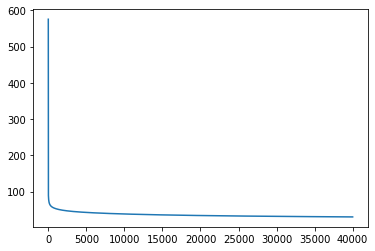

In [127]:
plt.plot(J)

In [128]:
Xs

array([[0.0084, 0.0153, 0.0291, ..., 0.0031, 0.0072, 0.0045],
       [0.0207, 0.0535, 0.0334, ..., 0.009 , 0.007 , 0.0099],
       [0.026 , 0.0363, 0.0136, ..., 0.0036, 0.0061, 0.0115],
       ...,
       [0.0239, 0.0189, 0.0466, ..., 0.0026, 0.0036, 0.0024],
       [0.0317, 0.0956, 0.1321, ..., 0.0143, 0.0036, 0.0103],
       [0.0209, 0.0261, 0.012 , ..., 0.0288, 0.0129, 0.0023]])

In [129]:
h = sigmoide(dot(Xs, wf))
for y, yh in zip(yt, h):
    print("real {} : yh {} ".format(y,np.round(yh)))


real 0 : yh [0.] 
real 0 : yh [1.] 
real 0 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [0.] 
real 0 : yh [0.] 
real 1 : yh [0.] 
real 1 : yh [1.] 
real 0 : yh [1.] 
real 0 : yh [0.] 
real 0 : yh [1.] 
real 0 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 0 : yh [0.] 
real 0 : yh [0.] 
real 0 : yh [1.] 
real 0 : yh [1.] 
real 0 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [0.] 
real 0 : yh [1.] 
real 1 : yh [0.] 
real 1 : yh [0.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 0 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [0.] 
real 0 : yh [0.] 
real 1 : yh [0.] 
real 1 : yh [0.] 
real 0 : yh [1.] 
real 0 : yh [0.] 
real 1 : yh [0.] 
real 0 : yh [0.] 
real 0 : yh [1.] 
real 1 : yh [1.] 
real 0 : yh [0.] 
real 0 : yh [1.] 
real 0 : yh [1.] 
real 0 : yh [1.] 
real 0 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 0 : yh [0.] 
real 1 : yh [0.] 
real 1 : yh [1.] 


In [130]:
confusion_matrix(ys, np.round(h))

array([[14,  9],
       [ 6, 23]])

In [131]:
def pca(datos, dimensiones=2):
    m,n = datos.shape
    D = datos[:]; D-= datos.mean(axis=0)
    R = cov(D, rowvar=False)
    evals, evecs = eig(R)
    idx = argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]
    evecs = evecs[:, :dimensiones]
    return dot(evecs.T, D.T).T, evals, evecs

data_pca, Z, V = pca(data, 16)


In [132]:
Xt, Xs, yt, ys = train_test_split(data_pca,clsf)
wf, W, J = grad_desc(Xt,yt,40000,0.1)

0:[92.49845386]
100:[62.13181892]
200:[62.07389204]
300:[62.07214024]
400:[62.07207454]
500:[62.07207198]
600:[62.07207188]
700:[62.07207187]
800:[62.07207187]
900:[62.07207187]
1000:[62.07207187]
1100:[62.07207187]
1200:[62.07207187]
1300:[62.07207187]
1400:[62.07207187]
1500:[62.07207187]
1600:[62.07207187]
1700:[62.07207187]
1800:[62.07207187]
1900:[62.07207187]
2000:[62.07207187]
2100:[62.07207187]
2200:[62.07207187]
2300:[62.07207187]
2400:[62.07207187]
2500:[62.07207187]
2600:[62.07207187]
2700:[62.07207187]
2800:[62.07207187]
2900:[62.07207187]
3000:[62.07207187]
3100:[62.07207187]
3200:[62.07207187]
3300:[62.07207187]
3400:[62.07207187]
3500:[62.07207187]
3600:[62.07207187]
3700:[62.07207187]
3800:[62.07207187]
3900:[62.07207187]
4000:[62.07207187]
4100:[62.07207187]
4200:[62.07207187]
4300:[62.07207187]
4400:[62.07207187]
4500:[62.07207187]
4600:[62.07207187]
4700:[62.07207187]
4800:[62.07207187]
4900:[62.07207187]
5000:[62.07207187]
5100:[62.07207187]
5200:[62.07207187]
5300:

In [135]:
h = sigmoide(dot(Xs, wf))
for y, yh in zip(yt, h):
    print("real {} : yh {} ".format(y,np.round(yh)))


real 0 : yh [0.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 0 : yh [0.] 
real 0 : yh [0.] 
real 1 : yh [1.] 
real 0 : yh [0.] 
real 0 : yh [0.] 
real 1 : yh [0.] 
real 0 : yh [1.] 
real 1 : yh [0.] 
real 0 : yh [1.] 
real 0 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [0.] 
real 0 : yh [0.] 
real 1 : yh [1.] 
real 0 : yh [0.] 
real 1 : yh [1.] 
real 0 : yh [0.] 
real 1 : yh [0.] 
real 1 : yh [1.] 
real 0 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [0.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 0 : yh [0.] 
real 0 : yh [1.] 
real 1 : yh [0.] 
real 0 : yh [0.] 
real 1 : yh [0.] 
real 0 : yh [1.] 
real 1 : yh [0.] 
real 1 : yh [1.] 
real 0 : yh [0.] 
real 0 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 0 : yh [1.] 
real 0 : yh [0.] 
real 1 : yh [1.] 
real 1 : yh [0.] 
real 0 : yh [1.] 
real 0 : yh [0.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 1 : yh [0.] 
real 1 : yh [1.] 
real 1 : yh [1.] 
real 0 : yh [1.] 
real 1 : yh [1.] 


In [136]:
confusion_matrix(ys, np.round(h))

array([[18,  8],
       [ 5, 21]])